In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm, moment
from scipy.optimize import minimize

from cosmoprimo import *
from pycorr import TwoPointCorrelationFunction

from densitysplit import catalog_data, density_split
from densitysplit.model import *
from densitysplit.corr_func_utils import *
from densitysplit.utils import *

plt.style.use(os.path.join(os.path.abspath(''), 'densitysplit.mplstyle'))

# To activate logging
setup_logging()

2024-06-06 19:06:55.397778: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:67] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /datablock:/feynman/work/dphp/adematti/cosmodesiconda/20230918-1.0.0/conda/lib:/feynman/work/dphp/adematti/cosmo/cosmodesiconda/20230918-1.0.0/common/planck/code/plc_3.0/plc-3.1/lib:/opt/rhel-7.x86_64/gnu/hdf5/1.12.0/lib:/opt/rhel-7.x86_64/gnu4.9/openmpi/1.10.2/lib:/opt/rhel-7.x86_64/gnu/gsl/2.1/lib:/feynman/work/dphp/adematti/cosmodesiconda/20230918-1.0.0/aux/lib
2024-06-06 19:06:55.397819: W external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:264] failed call to cuInit: UNKNOWN ERROR (303)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Global parameters

In [3]:
# Mock parameters
boxsize = 2000
boxcenter = 1000
nmesh = 1024
cosmology=fiducial.AbacusSummitBase()
z = 1.175
bias = 1.8
ells = [0]
nells = len(ells)

# Density smoothing parameters
cellsize = 10
resampler = 'tsc'

In [6]:
model = SplitCCFModel(redshift=z, cosmology=cosmology, bias=1, nbar=nbar, damping=False)

/feynman/work/dphp/adematti/cosmodesiconda/20230918-1.0.0/code/cosmoprimo/main/lib/python3.10/site-packages/cosmoprimo/interpolator.py:359: ComplexWarning: Casting complex values to real discards the imaginary part
  x, y = (np.asarray(xx, dtype=dtype) for xx in (x, y))


## Bias

[000080.50]  02-12 10:48  TwoPointEstimator            INFO     Loading /feynman/work/dphp/mp270220/outputs/correlation_functions/AbacusSummit_2Gpc_z1.175_2PCF.npy.


/feynman/work/dphp/adematti/cosmodesiconda/20230918-1.0.0/conda/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


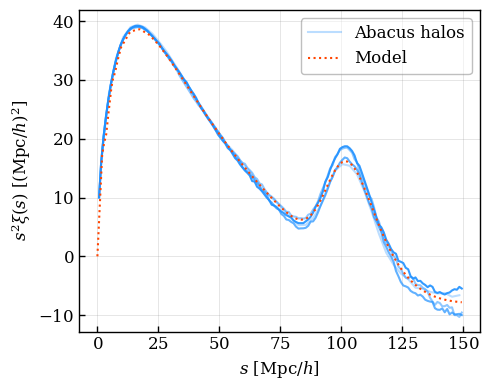

In [7]:
from pycorr import TwoPointCorrelationFunction

ells = [0]

# Abacus 2PCF
output_dir = '/feynman/work/dphp/mp270220/outputs/correlation_functions/'
xi_abacus_ph000 = TwoPointCorrelationFunction.load(output_dir+'AbacusSummit_2Gpc_z{:.3f}_2PCF.npy'.format(z))
s, xi_ells_abacus_ph000 = xi_abacus_ph000.get_corr(ells=ells, return_sep=True)

xi_abacus_ph001 = np.load(output_dir+'AbacusSummit_2Gpc_z{:.3f}_ph001_2PCF.npy'.format(z), allow_pickle=True)
sep, xi_ells_abacus_ph001 = xi_abacus_ph001.item().get_corr(ells=ells, return_sep=True)

xi_abacus_ph002 = np.load(output_dir+'AbacusSummit_2Gpc_z{:.3f}_ph002_2PCF.npy'.format(z), allow_pickle=True)
sep, xi_ells_abacus_ph002 = xi_abacus_ph002.item().get_corr(ells=ells, return_sep=True)

xi_abacus_ph003 = np.load(output_dir+'AbacusSummit_2Gpc_z{:.3f}_ph003_2PCF.npy'.format(z), allow_pickle=True)
sep, xi_ells_abacus_ph003 = xi_abacus_ph003.item().get_corr(ells=ells, return_sep=True)

bias = 1.83 # adjusted to match xi from particles and halos

for ill, ell in enumerate(ells):
    plt.plot(s, s**2 * xi_ells_abacus_ph000[ill], label='Abacus halos', color='C0', alpha=0.3)
    plt.plot(sep, sep**2 * xi_ells_abacus_ph001[ill], color='C0', alpha=0.5)
    plt.plot(sep, sep**2 * xi_ells_abacus_ph002[ill], color='C0', alpha=0.7)
    plt.plot(sep, sep**2 * xi_ells_abacus_ph003[ill], color='C0', alpha=0.9)
    plt.plot(model.sep, model.sep**2 * bias**2 * model.xi, label=r'Model', ls=':', color='C1')

plt.ylabel(r'$s^2 \xi(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.xlabel(r'$s$ [$\mathrm{Mpc}/h$]')
plt.legend()
plt.show()

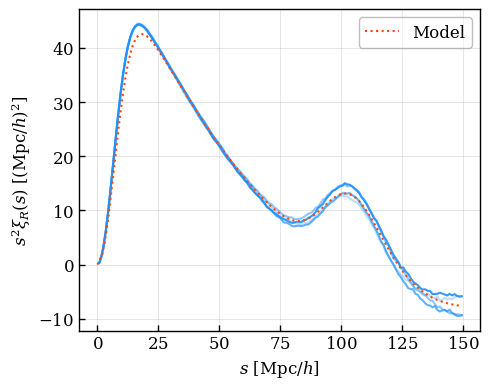

In [8]:
# Abacus smoothed 2PCF
output_dir = '/feynman/work/dphp/mp270220/outputs/correlation_functions/'
xiR_abacus_ph000 = np.load(output_dir+'AbacusSummit_2Gpc_z{:.3f}_cellsize{:d}_resampler{}_xi_R.npy'.format(z, cellsize, resampler), allow_pickle=True)
xiR_abacus_ph001 = np.load(output_dir+'AbacusSummit_2Gpc_z{:.3f}_ph001_cellsize{:d}_resampler{}_xi_R.npy'.format(z, cellsize, resampler), allow_pickle=True)
xiR_abacus_ph002 = np.load(output_dir+'AbacusSummit_2Gpc_z{:.3f}_ph002_cellsize{:d}_resampler{}_xi_R.npy'.format(z, cellsize, resampler), allow_pickle=True)
xiR_abacus_ph003 = np.load(output_dir+'AbacusSummit_2Gpc_z{:.3f}_ph003_cellsize{:d}_resampler{}_xi_R.npy'.format(z, cellsize, resampler), allow_pickle=True)
sep, xiR_ells_abacus_ph000 = xiR_abacus_ph000.item().get_corr(ells=ells, return_sep=True)
sep, xiR_ells_abacus_ph001 = xiR_abacus_ph001.item().get_corr(ells=ells, return_sep=True)
sep, xiR_ells_abacus_ph002 = xiR_abacus_ph002.item().get_corr(ells=ells, return_sep=True)
sep, xiR_ells_abacus_ph003 = xiR_abacus_ph003.item().get_corr(ells=ells, return_sep=True)

for ill, ell in enumerate(ells):
    plt.plot(sep, sep**2 * xiR_ells_abacus_ph000[ill], color='C0', alpha=0.3)
    plt.plot(sep, sep**2 * xiR_ells_abacus_ph001[ill], color='C0', alpha=0.5)
    plt.plot(sep, sep**2 * xiR_ells_abacus_ph002[ill], color='C0', alpha=0.7)
    plt.plot(sep, sep**2 * xiR_ells_abacus_ph003[ill], color='C0', alpha=0.9)
    plt.plot(model.sep, model.sep**2 * bias**2 * model.xi_R, label=r'Model', ls=':', color='C1')

plt.ylabel(r'$s^2 \xi_{R}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.xlabel(r'$s$ [$\mathrm{Mpc}/h$]')
plt.legend()
plt.show()

In [9]:
# shot noise correction
wfield = model.smoothing_kernel_3D.c2r() / model.boxsize**3
sep, mu, w = project_to_basis(wfield, edges=(model.s, np.array([-1., 1.])), exclude_zero=False)[0][:3]
shotnoise = np.real(w / nbar)

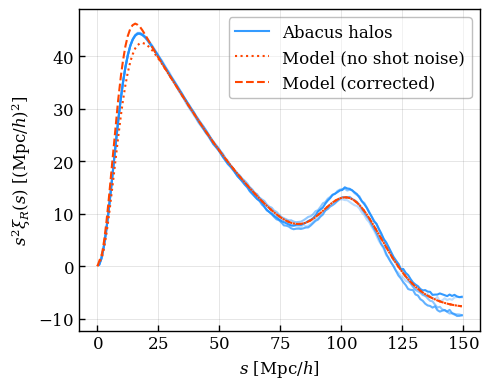

In [10]:
sep, xiR_ells_abacus_ph000 = xiR_abacus_ph000.item().get_corr(ells=ells, return_sep=True)

for ill, ell in enumerate(ells):
    plt.plot(sep, sep**2 * xiR_ells_abacus_ph000[ill], color='C0', alpha=0.3)
    plt.plot(sep, sep**2 * xiR_ells_abacus_ph001[ill], color='C0', alpha=0.5)
    plt.plot(sep, sep**2 * xiR_ells_abacus_ph002[ill], color='C0', alpha=0.7)
    plt.plot(sep, sep**2 * xiR_ells_abacus_ph003[ill], color='C0', alpha=0.9, label=r'Abacus halos')
    plt.plot(model.sep, model.sep**2 * bias**2 * (model.xi_R), label=r'Model (no shot noise)', ls=':', color='C1')
    plt.plot(model.sep, model.sep**2 * bias**2 * (model.xi_R + shotnoise), label=r'Model (corrected)', ls='--', color='C1')

plt.ylabel(r'$s^2 \xi_{R}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.xlabel(r'$s$ [$\mathrm{Mpc}/h$]')
plt.legend()
plt.show()

## Mock $\delta_R$

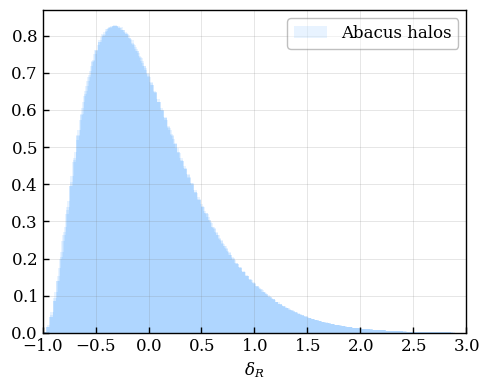

In [11]:
# halos
abacus_ph000_delta_R = np.load('/feynman/work/dphp/mp270220/data/AbacusSummit_2Gpc_z{:.3f}_cellsize{:d}_resampler{}_delta_R.npy'.format(z, cellsize, resampler))
abacus_ph001_delta_R = np.load('/feynman/work/dphp/mp270220/data/AbacusSummit_2Gpc_z{:.3f}_ph001_cellsize{:d}_resampler{}_delta_R.npy'.format(z, cellsize, resampler))
abacus_ph002_delta_R = np.load('/feynman/work/dphp/mp270220/data/AbacusSummit_2Gpc_z{:.3f}_ph002_cellsize{:d}_resampler{}_delta_R.npy'.format(z, cellsize, resampler))
abacus_ph003_delta_R = np.load('/feynman/work/dphp/mp270220/data/AbacusSummit_2Gpc_z{:.3f}_ph003_cellsize{:d}_resampler{}_delta_R.npy'.format(z, cellsize, resampler))

pdf_ph000 = plt.hist(abacus_ph000_delta_R, bins=200, density=True, color='C0', alpha=0.1, label='Abacus halos')
plt.hist(abacus_ph001_delta_R, bins=200, density=True, color='C0', alpha=0.1)
plt.hist(abacus_ph002_delta_R, bins=200, density=True, color='C0', alpha=0.1)
plt.hist(abacus_ph003_delta_R, bins=200, density=True, color='C0', alpha=0.1)
plt.xlabel(r'$\delta_R$')
plt.xlim((-1, 3))
plt.legend()
plt.show()

In [31]:
def compute_delta0_sigma(delta_R, m2=None, m3=None):
    if m2 is None:
        m2 = moment(delta_R, 2)
    if m3 is None:
        m3 = moment(delta_R, 3)
    def tomin(delta0):
        return (m3 - 3/delta0 * m2**2 - 1/delta0**3 * m2**3)**2
    res = minimize(tomin, x0=1.)
    print(res)
    delta0 = res.x[0]
    sigma = np.sqrt(np.log(1 + m2/res.x[0]**2))
    return delta0, sigma

delta0, sigma = compute_delta0_sigma(abacus_ph000_delta_R)
print(delta0)
print(sigma)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 5.2404341818501116e-11
        x: [ 1.641e+00]
      nit: 8
      jac: [-1.689e-06]
 hess_inv: [[ 3.543e+01]]
     nfev: 18
     njev: 9
1.6413941938047854
0.3283378816483833


## Model for $\delta_R$

In [32]:
def friedrich_lognormal_model(delta, sigma, delta0):
    pdf_model = np.zeros_like(delta)
    pdf_model[delta > -delta0] = scipy.stats.lognorm.pdf(delta[delta > -delta0], sigma, -delta0, delta0 * np.exp(-sigma**2 / 2))
    return pdf_model

In [33]:
def to_minimize(params, *args):
    pdf = args
    x = pdf[0]
    y = friedrich_lognormal_model((pdf[1][1:]+pdf[1][:-1])/2., params[0], params[1])
    return np.sum((x-y)**2)

min_ph000 = minimize(to_minimize, x0=np.array([model.sigma_RR[0], 1.]), args=pdf_ph000)
print(min_ph000)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.022866951842107353
        x: [ 4.142e-01  1.358e+00]
      nit: 14
      jac: [-4.238e-08 -1.676e-08]
 hess_inv: [[ 5.101e-02 -1.417e-01]
            [-1.417e-01  4.320e-01]]
     nfev: 54
     njev: 18


In [34]:
# shot noise correction for sigma_RR
fourier_kernel = model.smoothing_kernel_3D
norm_fourier_kernel = fourier_kernel / model.boxsize**3
real_space_kernel = norm_fourier_kernel.c2r()
real_space_kernel.value = np.real(real_space_kernel.value)
w2 = integrate_pmesh_field(real_space_kernel**2)
shotnoise_sigma = w2 / nbar

def to_minimize(delta0, *args):
    shotnoise = args[2]
    sigma = np.sqrt(np.log(1 + bias**2 * (model.sigma_RR**2 + shotnoise)/delta0**2))
    x = args[0]
    y = friedrich_lognormal_model((args[1][1:]+args[1][:-1])/2., sigma, delta0)
    return np.sum((x-y)**2)

def compute_bestfit_delta0(delta_R_pdf, return_sigma=True, shotnoise=0):
    res = minimize(to_minimize, x0=bias, args=(delta_R_pdf[0], delta_R_pdf[1], shotnoise))
    print(res)
    delta0 = res.x[0]
    sigma = np.sqrt(np.log(1 + bias**2 * (model.sigma_RR**2 + shotnoise)/delta0**2))
    return delta0, sigma

delta0_2, sigma_2 = compute_bestfit_delta0(pdf_ph000, shotnoise=shotnoise_sigma)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.022964788556282666
        x: [ 1.362e+00]
      nit: 5
      jac: [ 2.275e-06]
 hess_inv: [[ 3.580e-01]]
     nfev: 14
     njev: 7


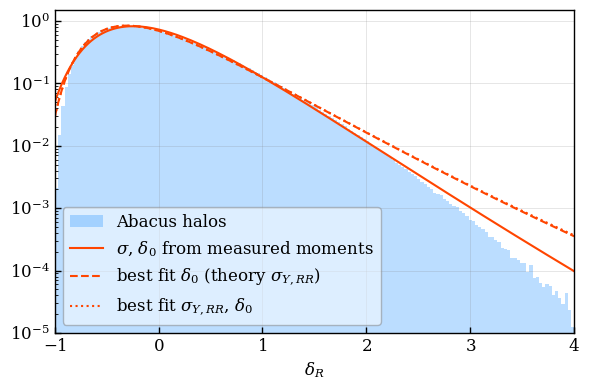

In [36]:
plt.rcParams["figure.figsize"] = (6, 4)

plt.hist(abacus_ph000_delta_R, bins=200, density=True, alpha=0.3, color='C0', label=r'Abacus halos')
delta = np.linspace(-delta0, 4, 200)
plt.plot(delta, friedrich_lognormal_model(delta, sigma, delta0), color='C1', label=r'$\sigma$, $\delta_0$ from measured moments')
plt.plot(delta, friedrich_lognormal_model(delta, sigma_2, delta0_2), color='C1', ls='--', label=r'best fit $\delta_0$ (theory $\sigma_{Y, RR}$)')
plt.plot(delta, friedrich_lognormal_model(delta, min_ph000.x[0], min_ph000.x[1]), color='C1', ls=':', label=r'best fit $\sigma_{Y, RR}$, $\delta_0$')
#plt.plot(delta, friedrich_lognormal_model(delta, bias*np.sqrt(np.log(1 + (model.sigma_RR/bias)**2)), bias), color='C0', ls=':', label=r'$\sigma$ = $b \sqrt{\ln(1 + (\sigma_{RR}/b)^2)}$, $\delta_0 = b$')
plt.xlabel(r'$\delta_R$')
plt.xlim((-1, 4))
plt.yscale('log')
plt.ylim((1e-5, 1.5))
plt.legend()
plt.show()

In [37]:
th_bins = scipy.stats.lognorm.ppf([0, 1./3, 2./3, 1], sigma, -delta0, delta0*np.exp(-sigma**2/2.))
th_bins

array([-1.64139419, -0.2912397 ,  0.15013079,         inf])

## Lognormal model for density splits

In [38]:
nsplits = 3

In [39]:
def compute_main_term(delta, sigma, delta0=1., delta0_R=1., bias=1., xi_R=None, shotnoise=None):
    if xi_R is None:
        xi_R = model.xi_R * bias**2
        if shotnoise is not None:
            xi_R = (model.xi_R + shotnoise) * bias**2
    if math.isfinite(delta):
        a = scipy.special.erf((np.log(1 + delta/delta0_R) + sigma**2/2. - np.log(1 + xi_R/(delta0*delta0_R))) / (np.sqrt(2) * sigma))
        b = scipy.special.erf((np.log(1 + delta/delta0_R) + sigma**2/2.) / (np.sqrt(2) * sigma))
    else:
        if delta > 0:
            a = np.full_like(model.xi_R, 1)
            b = np.full_like(model.xi_R, 1)
        if delta < 0:
            a = np.full_like(model.xi_R, -1)
            b = np.full_like(model.xi_R, -1)
    return a, b

def compute_dsplits(sigma, delta0=1., delta0_R=1., th_bins=th_bins, bias=1., xi_R=None, shotnoise=None):
    dsplits = list()

    for i in range(len(th_bins)-1):
        d1 = max(th_bins[i], -delta0_R)
        d2 = th_bins[i+1]
        a1, b1 = compute_main_term(d1, sigma, delta0=delta0, delta0_R=delta0_R, bias=bias, xi_R=xi_R, shotnoise=shotnoise)
        a2, b2 = compute_main_term(d2, sigma, delta0=delta0, delta0_R=delta0_R, bias=bias, xi_R=xi_R, shotnoise=shotnoise)
        main_term = (a2 - a1) / (b2 - b1)
        dsplits.append(delta0*(main_term - 1))

    return dsplits

/tmp/ipykernel_3256384/1906400520.py:7: RuntimeWarning: divide by zero encountered in log
  a = scipy.special.erf((np.log(1 + delta/delta0_R) + sigma**2/2. - np.log(1 + xi_R/(delta0*delta0_R))) / (np.sqrt(2) * sigma))
/tmp/ipykernel_3256384/1906400520.py:8: RuntimeWarning: divide by zero encountered in log
  b = scipy.special.erf((np.log(1 + delta/delta0_R) + sigma**2/2.) / (np.sqrt(2) * sigma))


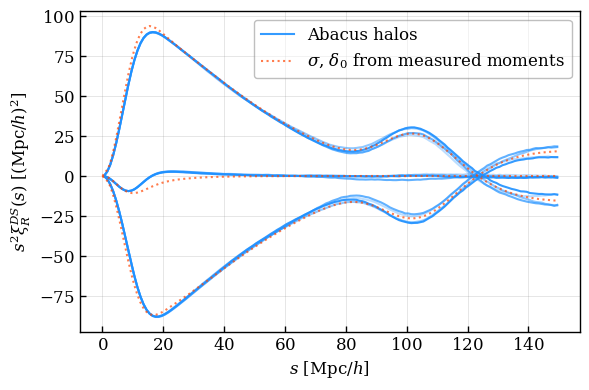

In [41]:
dsplits1 = compute_dsplits(sigma=sigma, delta0=bias, delta0_R=delta0, bias=bias, xi_R=None, shotnoise=shotnoise)
dsplits2 = compute_dsplits(sigma=min_ph000.x[0], delta0=bias, delta0_R=min_ph000.x[1], bias=bias, xi_R=None, shotnoise=shotnoise)
dsplits3 = compute_dsplits(sigma=sigma_2, delta0=bias, delta0_R=delta0_2, bias=bias, xi_R=None, shotnoise=shotnoise)

# Abacus density splits
split_xi_ph000 = np.load(output_dir+'AbacusSummit_2Gpc_z{:.3f}_cellsize{:d}_resampler{}_{:d}splits_randoms_size4'.format(z, cellsize, resampler, nsplits)+'_RH_CCF.npy', allow_pickle=True)
split_xi_ph000 = split_xi_ph000.item()['rh']
split_xi_ells_ph000 = [split_xi_ph000[ds].get_corr(ells=ells) for ds in range(nsplits)]
sep, _ = split_xi_ph000[0].get_corr(ells=ells, return_sep=True)

split_xi_ph001 = np.load(output_dir+'AbacusSummit_2Gpc_z{:.3f}_ph001_cellsize{:d}_resampler{}_{:d}splits_randoms_size4'.format(z, cellsize, resampler, nsplits)+'_RH_CCF.npy', allow_pickle=True)
split_xi_ph001 = split_xi_ph001.item()['rh']
split_xi_ells_ph001 = [split_xi_ph001[ds].get_corr(ells=ells) for ds in range(nsplits)]

split_xi_ph002 = np.load(output_dir+'AbacusSummit_2Gpc_z{:.3f}_ph002_cellsize{:d}_resampler{}_{:d}splits_randoms_size4'.format(z, cellsize, resampler, nsplits)+'_RH_CCF.npy', allow_pickle=True)
split_xi_ph002 = split_xi_ph002.item()['rh']
split_xi_ells_ph002 = [split_xi_ph002[ds].get_corr(ells=ells) for ds in range(nsplits)]

split_xi_ph003 = np.load(output_dir+'AbacusSummit_2Gpc_z{:.3f}_ph003_cellsize{:d}_resampler{}_{:d}splits_randoms_size4'.format(z, cellsize, resampler, nsplits)+'_RH_CCF.npy', allow_pickle=True)
split_xi_ph003 = split_xi_ph003.item()['rh']
split_xi_ells_ph003 = [split_xi_ph003[ds].get_corr(ells=ells) for ds in range(nsplits)]

for ill, ell in enumerate(ells):
    for ds in range(nsplits):
        plt.plot(sep, sep**2 * split_xi_ells_ph000[ds][0], ls='-', color='C0', alpha=0.3)
        plt.plot(sep, sep**2 * split_xi_ells_ph001[ds][0], ls='-', color='C0', alpha=0.5)
        plt.plot(sep, sep**2 * split_xi_ells_ph002[ds][0], ls='-', color='C0', alpha=0.7)
        plt.plot(sep, sep**2 * split_xi_ells_ph003[ds][0], label=r'Abacus halos' if ds==0 else '', ls='-', color='C0', alpha=0.9)
        plt.plot(model.sep, model.sep**2 * dsplits1[ds], ls=':', color='C1', alpha=0.7, label=r'$\sigma$, $\delta_0$ from measured moments' if ds==0 else '')
        #plt.plot(model.sep, model.sep**2 * dsplits2[ds], ls=':', color='C1', alpha=0.7, label=r'best fit $\sigma$, $\delta_0$' if ds==0 else '')
        #plt.plot(model.sep, model.sep**2 * dsplits3[ds], ls=':', color='C1', alpha=0.7, label=r'best fit $\delta_0$ (theory $\sigma_{Y, RR}$)' if ds==0 else '')
plt.xlabel(r'$s$ [$\mathrm{Mpc}/h$]')
plt.ylabel(r'$s^2 \xi_{R}^{DS}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.ylabel(r'$s^2 \xi_{R}^{DS}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.legend()
plt.show()